# Using Transfer Learning (with the Inceptionv3 Model) and Keras Wrapper to do cat vs dog recognition

## Imports

In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.utils import np_utils
from keras import backend as K
from PIL import Image
import numpy as np
import os

Using TensorFlow backend.


## Create base inception model, add fully-connected layer, freeze base layers, and compile

In [2]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# cat vs dog prediction
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

/Users/zachariahmiller/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


## Setting up images/class generator

In [3]:
# classes: dog = 1, cat = 0
width = 200
height = width

def augment(imgr):
    return imgr

def image_generator(basedir):
    cls = np.random.randint(0,1+1)
    fname = basedir
    if cls:
        fname += '/dog'
    else:
        fname += '/cat'
    imgpath = os.path.join(fname, np.random.choice(os.listdir(fname)))
    img = Image.open(imgpath)
    imgr = img.resize((width,height),resample=Image.ANTIALIAS)
    img_aug = augment(imgr)
    return img_aug, cls, imgpath

def get_batch(basedir, batch_size=25):
    batch=0
    images = np.empty(shape=(batch_size,width,height,3))
    classes = np.empty(shape=(batch_size))
    img_paths = []
    while batch < batch_size: 
        imag,clas,path = image_generator(basedir)
        images[batch] = imag
        images[batch]/= 255.
        classes[batch] = clas
        img_paths.append(path)
        batch+=1
    return images, classes, img_paths

## For checking if images are loading correctly

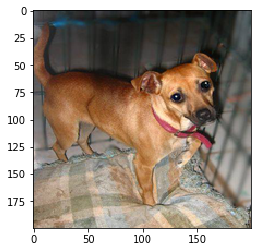

In [4]:
from matplotlib.pyplot import imshow
%matplotlib inline
images, classes, img_paths = get_batch('train', batch_size=10)
imshow(images[9])

## Actually train the fully connected layer

In [186]:
# Takes a long time, Only use if you are sure
"""
batch_size = 100
images_per_epoch = 10000
num_batches = int(images_per_epoch/batch_size)
num_epoch = 2

for epoch in range(num_epoch):
    for batch in range(num_batches):
        print "Epoch: "+str(epoch)+"; Batch: "+str(batch)
        images, classes, img_paths = get_batch('train',batch_size)
        target = np_utils.to_categorical(classes)
        model.fit(images, target, verbose=1, batch_size=batch_size)
"""


Epoch: 0; Batch: 0
Epoch 1/1
100/100 [==============================] - 19s - loss: 6.1107
Epoch: 0; Batch: 1
Epoch 1/1
100/100 [==============================] - 22s - loss: 0.4172
Epoch: 0; Batch: 2
Epoch 1/1
100/100 [==============================] - 20s - loss: 1.3476
Epoch: 0; Batch: 3
Epoch 1/1
100/100 [==============================] - 19s - loss: 3.6974
Epoch: 0; Batch: 4
Epoch 1/1
100/100 [==============================] - 20s - loss: 1.4524
Epoch: 0; Batch: 5
Epoch 1/1
100/100 [==============================] - 18s - loss: 1.1564
Epoch: 0; Batch: 6
Epoch 1/1
100/100 [==============================] - 20s - loss: 0.4881
Epoch: 0; Batch: 7
Epoch 1/1
100/100 [==============================] - 18s - loss: 0.5077
Epoch: 0; Batch: 8
Epoch 1/1
100/100 [==============================] - 18s - loss: 0.5409
Epoch: 0; Batch: 9
Epoch 1/1
100/100 [==============================] - 17s - loss: 0.3503
Epoch: 0; Batch: 10
Epoch 1/1
100/100 [==============================] - 17s - loss: 0.305

In [187]:
#model.save_weights('first_try.h5')

## Test Model

In [5]:
# use to load weights if you don't want to retrain
model.load_weights("first_try.h5")

In [264]:
pos_dog, pos_cat, neg_dog, neg_cat = 0, 0, 0, 0
num_val_images = 1000
images, classes, img_paths = get_batch('test',num_val_images)
target = np_utils.to_categorical(classes)
#scores = model.evaluate(images, target, verbose=1) # Checks log loss cross-entropy
predictions = model.predict(images, batch_size=num_val_images, verbose=1)

for ypred, ytrue in zip(predictions,classes):
    y = int(np.argmax(ypred))
    yt = int(ytrue)
    if yt == y:
        if yt:
            pos_dog+=1
        else:
            pos_cat+=1
    else:
        if yt:
            neg_dog+=1
        else:
            neg_cat+=1
            
acc = float(pos_dog+pos_cat)/float(len(classes))
print "Acc: " + str(acc)

1000/1000 [==============================] - 247s
Acc: 0.927


1/1 [==============================] - 0s
[[  9.99207914e-01   7.92119361e-04]]


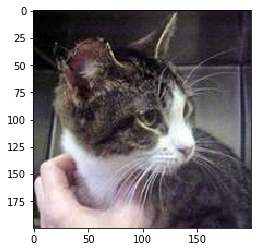

In [6]:
# Get a single sample from test and print prediction beside image
num_val_images = 1
images, classes, img_paths = get_batch('test',num_val_images)
target = np_utils.to_categorical(classes)
prediction = model.predict(images, batch_size=num_val_images, verbose=1)
imshow(images[0])
print prediction

## Predict on a Specific Image

1/1 [==============================] - 0s
[[ 0.15539505  0.84460497]]


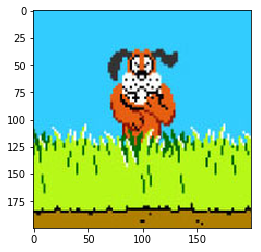

In [18]:
def image_to_predict(imgpath):
    img = Image.open(imgpath)
    imgr = img.resize((width,height),resample=Image.ANTIALIAS)
    img_data = np.array(imgr)/255.
    return img_data

img_to_predict = np.empty(shape=(1,200,200,3))
pic = image_to_predict('topredict/duckhuntdog.jpg')
img_to_predict[0] = pic
imshow(img_to_predict[0])
prediction = model.predict(img_to_predict, batch_size=1, verbose=1)
print prediction